In [ ]:
import importlib
import warnings
from typing import Any

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import special
from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis,
    QuadraticDiscriminantAnalysis,
)
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Prepare the data
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    cross_val_score,
    train_test_split,
)
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

# Suppress all warnings from LightGBM, they pollute notebook output
warnings.filterwarnings("ignore", module="lightgbm")

# Exploratory Data Analysis (EDA)

We obtain the dataset from the UC Irvine Machine Learning Repository. The data consists of physical measurements of kernels belonging to 3 different varieties of wheat. The measurements we extracted by using a custom-build X-ray photography setup and post-processing the results with purpose-built computer vision algorithms. The main references which describe the data are:
- [M. Charytanowicz, J. Niewczas, P. Kulczycki, P. A. Kowalski, S. Łukasik, and S. Żak, in Information Technologies in Biomedicine, edited by E. Piętka and J. Kawa (Springer-Verlag, Berlin Heidelberg, 2010), Vol. 69, p. 15.](https://www.semanticscholar.org/paper/24a9453d3cab64995e32506f884c2a1792a6d4ca)
- [M. Charytanowicz, P. Kulczycki, P. A. Kowalski, S. Łukasik, and R. Czabak-Garbacz, Comput. Electron. Agric. 144, 260 (2018)](https://www.sciencedirect.com/science/article/abs/pii/S0168169917301990)

In [2]:
def load_data(filename: str) -> pd.DataFrame:
    raw_data = np.genfromtxt(filename)
    cols = [
        "area",
        "perimeter",
        "compactness",
        "length_kernel",
        "width_kernel",
        "asymmetry_coeff",
        "length_kernel_groove",
        "variety",
    ]
    df = pd.DataFrame(raw_data, columns=cols)
    return df

In [3]:
df = load_data("./data/seeds_dataset.txt")

In [4]:
# Variety is a numerical label, make sure it's int, not float. Also make labels be 0-based
df["variety"] = df["variety"].astype(int) - 1

In [5]:
# Check for any missing data
df.isnull().sum()

area                    0
perimeter               0
compactness             0
length_kernel           0
width_kernel            0
asymmetry_coeff         0
length_kernel_groove    0
variety                 0
dtype: int64

There is no missing data in this data set. Let's get an overview of the properties of the data in each column

In [6]:
# Get an overview of the data
df.describe()

,area,perimeter,compactness,length_kernel,width_kernel,asymmetry_coeff,length_kernel_groove,variety
count,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000
mean,14.847524,14.559286,0.870999,5.628533,3.258605,3.700201,5.408071,1.000000
std,2.909699,1.305959,0.023629,0.443063,0.377714,1.503557,0.491480,0.818448
min,10.590000,12.410000,0.808100,4.899000,2.630000,0.765100,4.519000,0.000000
25%,12.270000,13.450000,0.856900,5.262250,2.944000,2.561500,5.045000,0.000000
50%,14.355000,14.320000,0.873450,5.523500,3.237000,3.599000,5.223000,1.000000
75%,17.305000,15.715000,0.887775,5.979750,3.561750,4.768750,5.877000,2.000000
max,21.180000,17.250000,0.918300,6.675000,4.033000,8.456000,6.550000,2.000000


We see that we have 210 instances of the data and 8 columns. `variety` is our target variable for prediction while the others describe the physical morphology of the seeds. Note that all of these features are real-valued. Furthermore, all of the columns contain only positive numbers as they are either measurements of quantities that only have positive values (`area, perimiter, length_kernel, width_kernel, length_kernel_grove`, which are all measured in mm, with the exception of area, which is measured in $mm^2$) or are positive by definition, as we will see below. 

<Axes: xlabel='variety', ylabel='Count'>

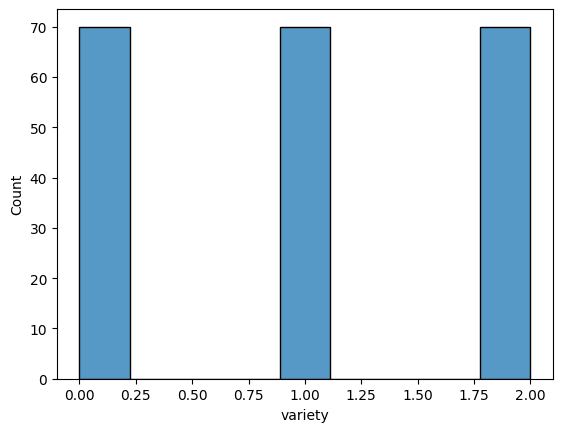

In [7]:
# Check how many varieties, i.e classes we have
sns.histplot(df, x="variety")

There are 3 unique varieties of wheat in the dataset, all with 70 samples each.

It's worth explicitly defining some of the less obvious features (see the Figure below, adapted from Charytanowicz et al, 2010)
- `length_kernel_groove`: the length of the kernel groove, which was the place where the kernel was attached to the stalk
- `compactness`, $C:=4\pi\times \frac{A}{P^2}$ describes the deviation of the kernel shape from a circle. Indeed for a circle, $C=4\pi\times \frac{\pi r^2}{4\pi^2r^2}=1$. Meanwhile the more elongated a shape becomes, the small the compactness is.
- `asymmetry_coeff`, $AC:=\frac{|A_{\rm left}-A_{\rm right}|}{A}$ where $A$ is the area of kernel, and $A_{\rm left},A_{\rm right}$ are the areas of the left and right of the kernel. For a kernel symmetric around the groove, $AC=0$. For a completely asymmetric kernel (in the limit where either $A_{\rm left}$ or $A_{\rm right}$ go to 0), $AC=1$



![hello](./images/kernel_wheat_annotated_new.png "Example of wheat properties measurement used in the dataset")

Let's do a pairwise plot of the features, coloring by wheat variety to see any correlations between variables and any potential clusters. Before doing so, we _already_ split the data into training and test set and we only use the training set. This is to prevent us from engaging in _data-snooping_, whereby knowing something about the full dataset might bias any modelling decisions, even if we do not _explicitly_ use any information from EDA in our modelling.

In [8]:
test_frac = 0.2
random_state = 27
np.random.seed(seed=random_state)


def split_data(
    df: pd.DataFrame, test_frac: float = 0.2, target_var="variety", random_state=27
):
    df_train, df_test = train_test_split(
        df, test_size=test_frac, random_state=random_state
    )
    y_train = df_train[target_var].values.astype("int")
    y_test = df_test[target_var].values.astype("int")

    df_train = df_train.drop(columns=[target_var])
    df_test = df_test.drop(columns=[target_var])

    df_train = df_train.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    return df_train, df_test, y_train, y_test


df_train, df_test, y_train, y_test = split_data(df, random_state=random_state)
X_train = df_train.values
X_test = df_test.values

In [9]:
df_explore = df_train.copy()
df_explore["variety"] = y_train

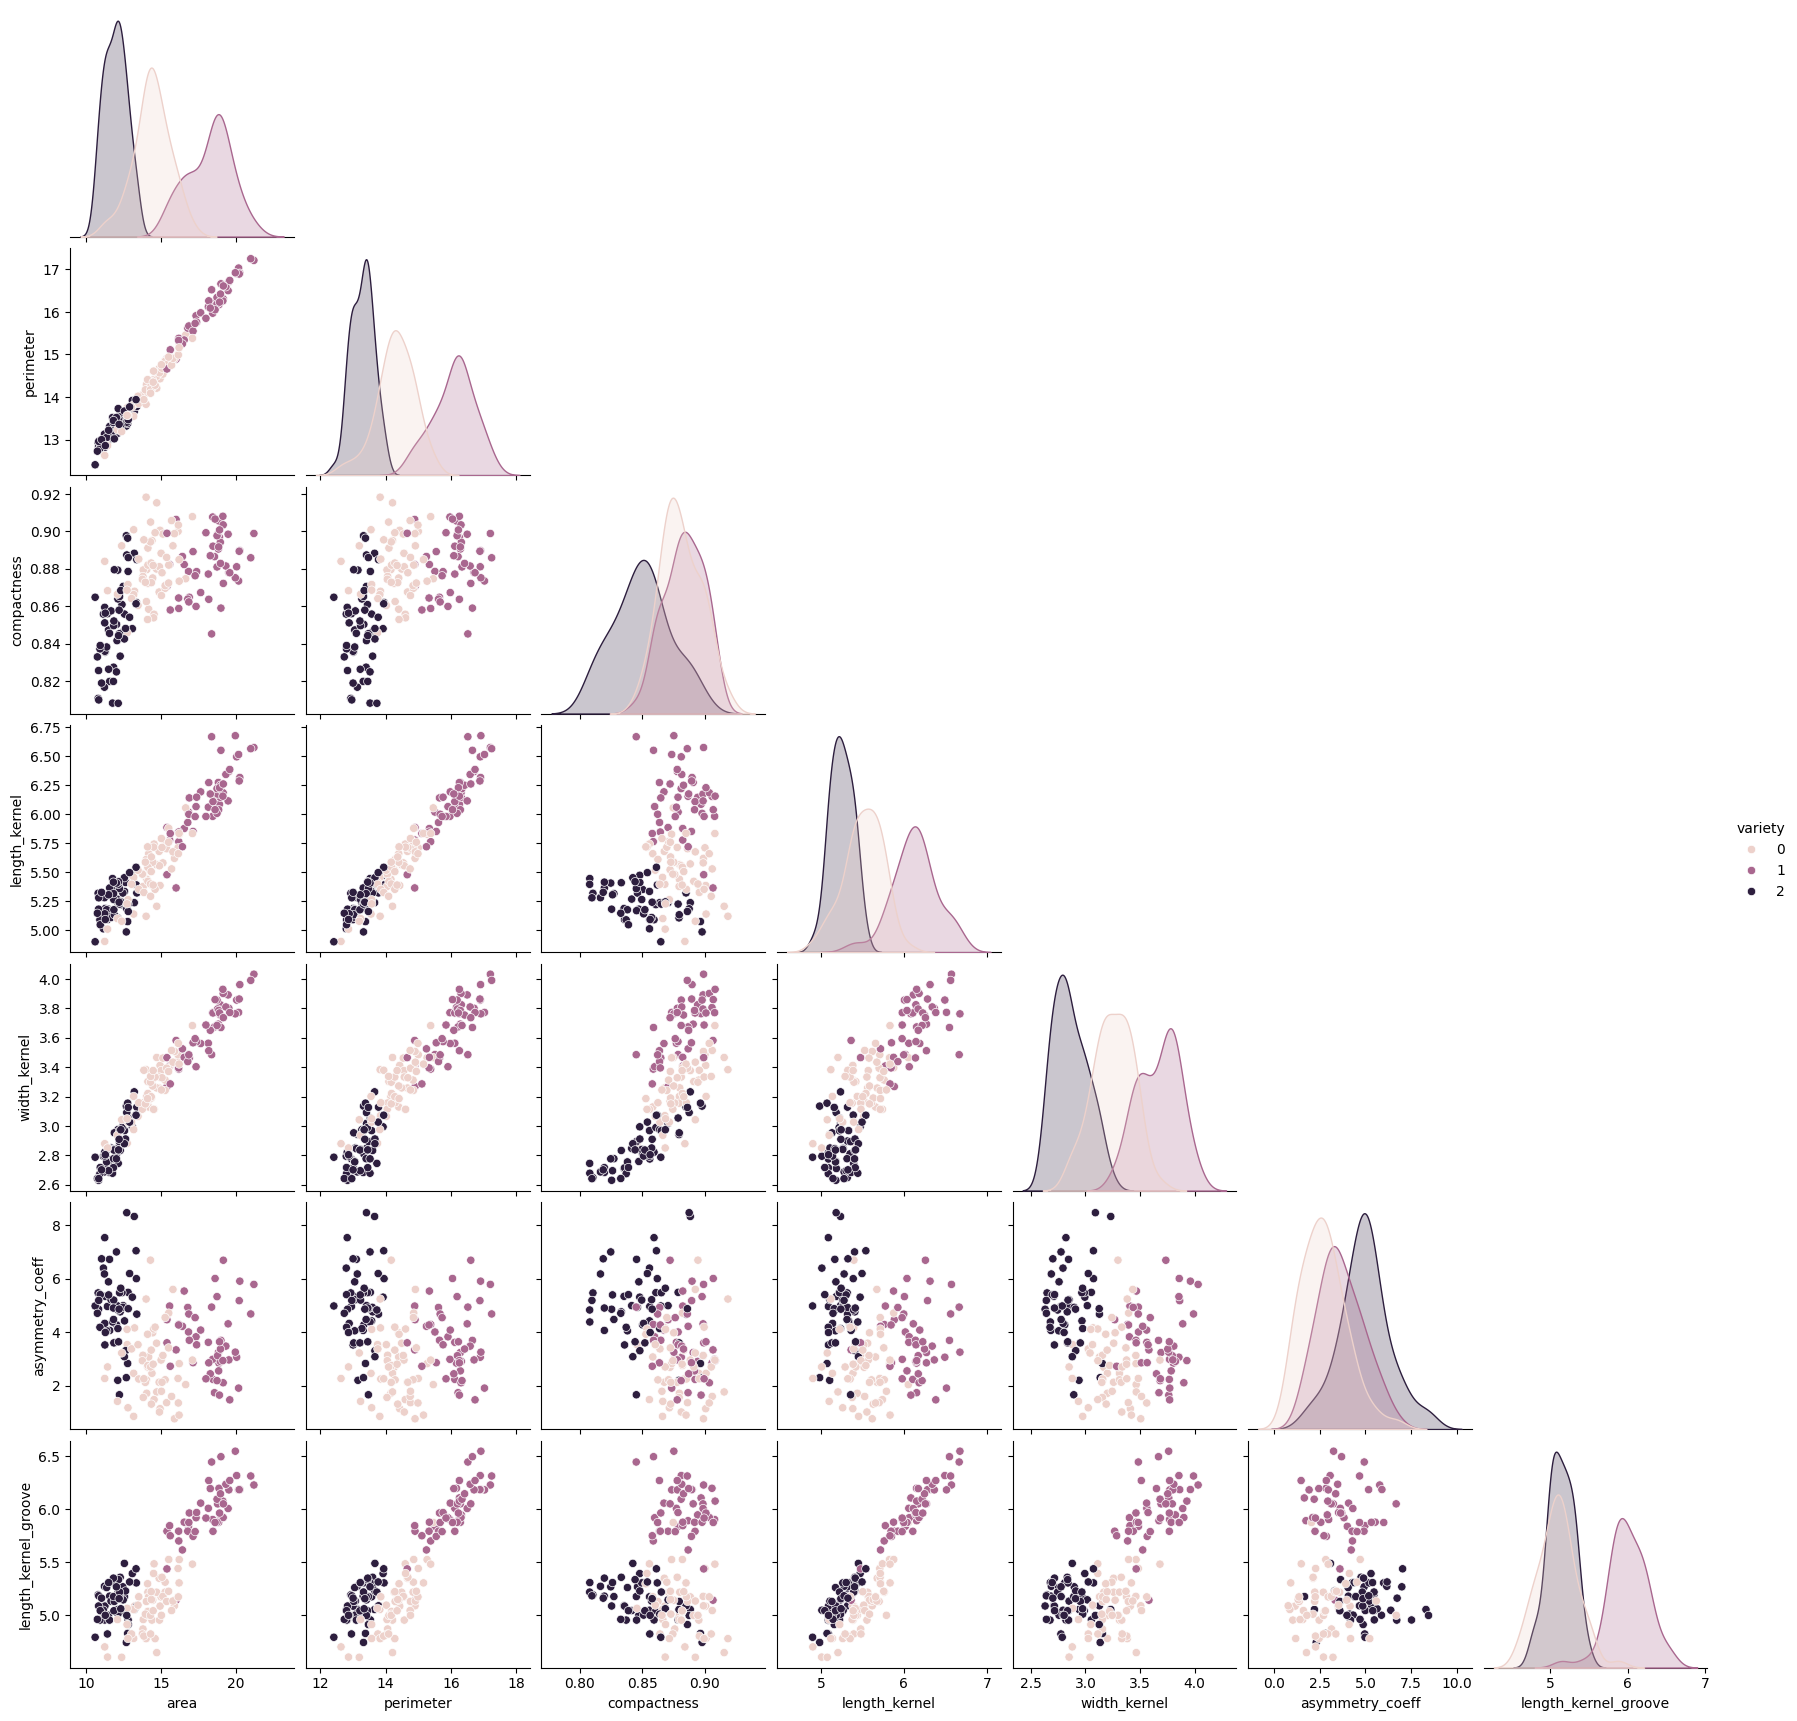

In [10]:
sns.pairplot(df_explore, hue="variety", corner=True)

A few things to note from the above:
- Unsurprisingly there is a strong correlation between length (and width) of the kernel and the area and perimeter variables. This is expected, since we expect both the area and perimiter to depend on the length and the width. To lowest order, we can approximate the shape of the kernel as an ellipse. In that case, we have
$$
\begin{align}
A &= \pi a b \\
P &= 4 a E (e^{2})
\end{align}
$$ 

where $a,b$ are half the length and widths of the kernel, $e^{2} = 1-\frac{b^2}{a^2}$ is the square of the eccentricity and $E(\cdot)$ is the Elliptic Integral of the 2nd kind. Indeed, both area and perimiter depend on the length and width of the kernel.
- We can see that some combinations of variables show clear separation of the wheat varieties (e.g. area and asymmetry coefficient), while others do not (e.g. compactness and length of kernel groove). We should expect that using all the physical charactersitics we should be able to classify the varieties



To give an intutive illustation of compactness, consider the case of an ellipse in more detail:

In [11]:
def exact_ellipse_cicumference(a, b):
    e_sq = 1 - b**2 / a**2
    return 4 * a * special.ellipe(e_sq)


def ellipse_area(a, b):
    return np.pi * a * b


def compactness(A, P):
    return 4 * np.pi * A / P**2

Text(0, 0.5, 'Semi-minor axis (b) [mm]')

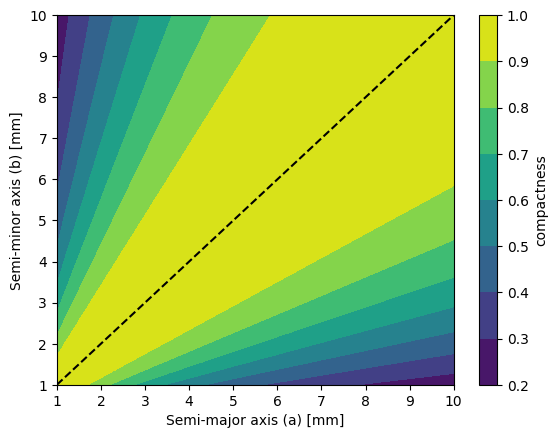

In [12]:
# Contour plot of compactness
a = np.linspace(1, 10, 50)
b = np.linspace(1, 10, 50)
A, B = np.meshgrid(a, b)
circ = exact_ellipse_cicumference(A, B)
area = ellipse_area(A, B)
plt.contourf(A, B, compactness(area, circ))
plt.colorbar(label="compactness")
plt.plot(a, a, ls="--", color="black")
plt.xlabel("Semi-major axis (a) [mm]")
plt.ylabel("Semi-minor axis (b) [mm]")

As one can see when $a=b$ (i.e we have a circle), indeed $C=1$. The larger $a>b$ (or vice versa) the smaller the value of compactness.

To confirm our observations about variable correlation, let's compute the correlation matrix between all indepedent variables.

In [13]:
corr = df_train.corr()

In [14]:
# Draw the heatmap with the mask and correct aspect ratio
corr.style.background_gradient(cmap="coolwarm")

,area,perimeter,compactness,length_kernel,width_kernel,asymmetry_coeff,length_kernel_groove
area,1.000000,0.993569,0.594910,0.940911,0.969877,-0.265417,0.845615
perimeter,0.993569,1.000000,0.508804,0.967416,0.941018,-0.247467,0.878167
compactness,0.594910,0.508804,1.000000,0.325794,0.756169,-0.372668,0.171310
length_kernel,0.940911,0.967416,0.325794,1.000000,0.844336,-0.192326,0.926473
width_kernel,0.969877,0.941018,0.756169,0.844336,1.000000,-0.297011,0.723669
asymmetry_coeff,-0.265417,-0.247467,-0.372668,-0.192326,-0.297011,1.000000,-0.016001
length_kernel_groove,0.845615,0.878167,0.171310,0.926473,0.723669,-0.016001,1.000000


Indeed we see that `area`,`perimeter`, `width_kernel` and `length_kernel` are all highly correlated, as we expected. Next, let's get a glimpse of how important different features are for classification by computing mutual information (MI) between each feature and the `variety` response variable.

In [15]:
mi = mutual_info_classif(df_train, y_train)
series = pd.Series(dict(zip(df_train.columns, mi))).sort_values(ascending=False)

In [16]:
series

area                    0.791674
perimeter               0.766812
width_kernel            0.693316
length_kernel           0.612595
length_kernel_groove    0.562505
compactness             0.281100
asymmetry_coeff         0.165657
dtype: float64

It's interesting to note that when computing the mutual information `area` has the highest MI while `asymmetry_coeff` has the lowest. Indeed consider the 1D distributions of `area` and `asymmetry_coeff`

<Axes: xlabel='asymmetry_coeff', ylabel='Density'>

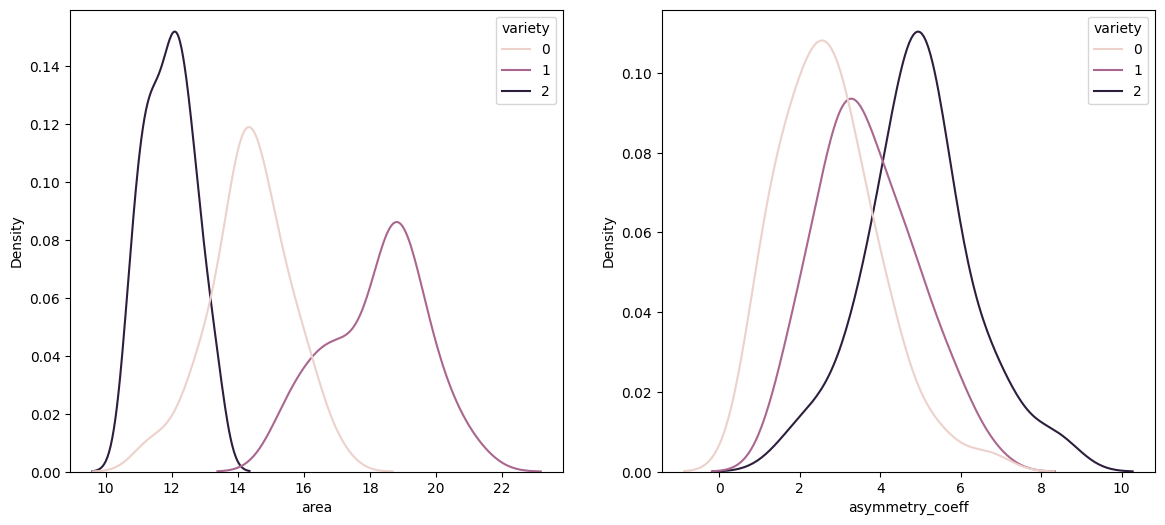

In [17]:
plt.figure(figsize=(14, 6))
plt.subplot(121)
sns.kdeplot(df_explore, x="area", hue="variety")
plt.subplot(122)
sns.kdeplot(df_explore, x="asymmetry_coeff", hue="variety")

We see a much cleaner separation among classes in the plot with `area` than in `asymmetry_coeff`. This is expected, since a high value of MI indicates a strong dependence of between the predictor and the class label, i.e. we expect the conditional distributions $P(X|Y=k)$ to be different for different classes $k$.

# Fitting a classification model

Due to the small size of the dataset we will adopt the following strategy for training, validation and testing:
- We split the data into train and test sets, 80% to 20%
- For the training we use 5-fold cross-validation to tune model parameters
- The final model is evaluation on the test set

We use the following models:
- Discriminative:
    - Logistic regression
    - k-Nearest Neighbors
    - (Kenel) Support Vector Machines (kSVM)
    - Random Forest Classifier
    - XGBoost
    - CatBoost
    - LightGBM

- Generative:
    - Linear/Quadratic Discriminant Analysis
    - Naive Bayes

For each model we tune some of the available tunable parameters. For example, for Logistic Regression which change the strength of regularization (C) and for tree-based methods the depth of the tree. 

## Background on some classification methods
### Support Vector Machines
Support Vector Machines aim to find the hyperplane that best separates members of 2 classes. It is built to solve a _binary_ classification problem, so in the context of multiple classes as in our problem here one can adopt the following 2 approaches:
- **One-vs-one**: create a binary classifier for every possible pair of classes. During inference, each classifier provides a vote of a particular point belonging to the 2 classes it was trained on. The final class is taken to be the majority vote among all trained classifiers
- **One-vs-all**: create a binary classifier for each class - either points belong to the class or not. In a problem with $n$ classes, this gives $n$ classifiers. During inference each classifier produces a score for the given point to belong to its class. The class with the highest score wins
We will use the One-vs-All approach here as it requires significantly fewer classifiers.
If the decision boundary is non-linear then SVMs will struggle to separate the classes. For such cases one can employ the [kernel trick](https://en.wikipedia.org/wiki/Kernel_method) which allows an implicit projection of the data to a higher-dimensional space where data can be linearly separated. This kernel trick requires a choice of kernel and thus will be one of the free parameters that need to be tuned.

Note that SVMs do not natively provide a probability for a given point to belong to a given class. Instead such a probability has to be computed separately. Fortunately, `sklearn` does it automatically. See more [here](https://scikit-learn.org/stable/modules/svm.html#scores-and-probabilities)

### Quadratic and Linear Discriminant Analysis

## Using K-fold Cross Validation to tune hyperparameters

In [18]:
kf = KFold(n_splits=5, shuffle=True, random_state=random_state)

As an example, we implement from scracth a CV-based search for hyperparameters of Logistic Regression. The idea is:
- pick values for hyperparameters in a grid
- for those values:
    - train the model 5 times, each time leaving out a different fold and computing an accuracy measure on the left out fold
    - average the accuracy measure across folds
- repeat for all values of hyperparameters
- take the hyperparameters that result in the best average accuracy measure


For the accuracy measure we choose the weighted $F_1$-score. See [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) for more information. 

In [19]:
# Implement a CV search for Logistic regression hyperparameters


def get_k_fold_metrics(
    X_train: np.ndarray,
    y_train: np.ndarray,
    kf: KFold,
    free_params: dict[str, Any] = {},
) -> np.ndarray:
    """Loop over every fold, train and evaluate the model on the held-out fold.
    Return the accuracy, macro and weighted averages of the f1-score averaged
    over all the folds.

    Args:
        X_train (np.ndarray): All training data
        y_train (np.ndarray): All training response variable
        kf (_type_): _description_
        free_params (dict[str, Any], optional): Free params to tune. Defaults to {}.

    Returns:
        np.ndarray: the accuracy measures averaged over all folds
    """
    res = []

    for i, (train_index, test_index) in enumerate(kf.split(X_train, y_train)):
        clf = LogisticRegression(max_iter=10000, **free_params)
        clf.fit(X_train[train_index], y_train[train_index])
        y_pred = clf.predict(X_train[test_index])
        y_true = y_train[test_index]

        report = classification_report(y_true, y_pred, output_dict=True)
        res.append(
            [
                report["accuracy"],
                report["macro avg"]["f1-score"],
                report["weighted avg"]["f1-score"],
            ]
        )
    res = np.array(res)
    means = np.mean(res, axis=0)
    return means


# Loop over the strength of regularization
# NOTE: The larger the number the **less** regularization there is!
Cs = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
ac = []
for C in Cs:
    ac.append(get_k_fold_metrics(X_train, y_train, kf, {"C": C}))
ac = np.array(ac)

In [20]:
# Find the best weighted F1-score
idx = np.argmax(ac[:, 2])
print(f"best value for C: {Cs[idx]}, whichs gives weighted f1-score:{ac[idx, 2]}")

best value for C: 1000, whichs gives weighted f1-score:0.9522499229859717


Thankfully `sklearn` already has a function to do this automatically for us. Let's check if it gives the same results

In [21]:
clf = LogisticRegression(max_iter=2000, random_state=random_state)
param_grid = {"C": Cs}
classifier = GridSearchCV(clf, param_grid, cv=kf, scoring="f1_weighted")
classifier.fit(X_train, y_train)
print(
    f" the best parameter is {classifier.best_params_}, which gives weighted f1-score: {classifier.best_score_}"
)

 the best parameter is {'C': 1000}, which gives weighted f1-score: 0.9522499229859717


Thus from now on, we will use GridSearchCV whenever we need to tune hyper-parameters. In addition, during cross-validation **|we will also use the MI score to select the best subset of predictors to include**.

# Systematic tuning of classification models

In [22]:
def get_model_by_name(full_model_name: str):
    parts = full_model_name.split(".")
    class_name = parts[-1]
    package_name = ".".join(parts[:-1])
    module = importlib.import_module(package_name)
    my_class = getattr(module, class_name)
    return my_class

## Discriminative models

In [23]:
def tune_hyper_params_cv(
    X: np.ndarray,
    y: np.ndarray,
    kf: KFold,
    full_model_name: str | None = None,
    fixed_params: dict[str, Any] = {},
    hyper_params: dict[str, Any] = {},
    scoring: str = "f1_weighted",
) -> tuple[dict[str, Any], float, list[str]]:
    """Tune model hyper-parameters as well as use mutual info to select best features to use via K-fold CV.

    Args:
        X (np.ndarray): Training data set independent variables
        y (np.ndarray): Training data set target variable
        kf (KFold): CV object
        full_model_name (str | None, optional): The full name of the model to tune. Defaults to None.
        fixed_params (dict[str, Any], optional): Any fixed custom params. Defaults to {}.
        hyper_params (dict[str, Any], optional): Hyper-parameters to tune, along with their ranges. Defaults to {}.
        scoring (str, optional): Scoring function to use. Defaults to "f1_weighted".

    Returns:
        tuple[dict[str,Any],float,list[str]]: Values of best hyper-parameters (including features),best score,
            names of selected features
    """
    # Load the model
    model = get_model_by_name(full_model_name)
    # Build the model with fixed parameters
    clf = model(**fixed_params)
    pipeline = Pipeline(
        [("feature_selection", SelectKBest(mutual_info_classif)), ("classifier", clf)]
    )
    hyper_params = {f"classifier__{k}": v for k, v in hyper_params.items()}
    hyper_params.update(feature_selection__k=[1, 3, 5, "all"])
    print(hyper_params)
    # Do CV search on the hyper-parameters
    classifier = GridSearchCV(pipeline, hyper_params, cv=kf, scoring=scoring)
    classifier.fit(X, y)
    # Store best parameters and score
    best_params, best_score = classifier.best_params_, classifier.best_score_
    mask = classifier.best_estimator_.named_steps["feature_selection"].get_support()
    selected_features = [df_train.columns[i] for i in np.where(mask)[0]]
    return best_params, best_score, selected_features

In [24]:
# Hyper-parameters for tree-based models that do gradient boosting
hyper_params_boosting_models = {
    "max_depth": [1, 2, 3, 4, 5],
    "n_estimators": [100, 500, 1000],
    "learning_rate": [0.01, 0.1, 1],
}

# Settings for all discriminative models
settings = {
    "LR": {
        "full_model_name": "sklearn.linear_model.LogisticRegression",
        "fixed_params": {"max_iter": 20000, "random_state": random_state},
        "hyper_params": {"C": Cs},
    },
    "SVC": {
        "full_model_name": "sklearn.svm.SVC",
        "fixed_params": {
            "max_iter": 20000,
            "probability": True,  # This must be enabled for SVC to output probabilities
            "random_state": random_state,
        },
        "hyper_params": {"C": Cs, "kernel": ["linear", "rbf"]},
    },
    "catboost": {
        "full_model_name": "catboost.CatBoostClassifier",
        "fixed_params": {
            "loss_function": "MultiClass",
            "verbose": False,
            "random_seed": random_state,
        },
        "hyper_params": hyper_params_boosting_models,
    },
    "lightgbm": {
        "full_model_name": "lightgbm.LGBMClassifier",
        "fixed_params": {
            "objective": "multiclass",
            "verbosity": -1,
            "random_state": random_state,
        },
        "hyper_params": hyper_params_boosting_models,
    },
    "xgboost": {
        "full_model_name": "xgboost.XGBClassifier",
        "fixed_params": {"objective": "multi:softmax", "random_state": random_state},
        "hyper_params": hyper_params_boosting_models,
    },
    "random_forest": {
        "full_model_name": "sklearn.ensemble.RandomForestClassifier",
        "fixed_params": {"random_state": random_state},
        "hyper_params": {
            "max_depth": [1, 2, 3, 4, 5],
            "n_estimators": [100, 500, 1000],
        },
    },
    "kNN": {
        "full_model_name": "sklearn.neighbors.KNeighborsClassifier",
        "fixed_params": {},
        "hyper_params": {"n_neighbors": [2, 5, 10, 15]},
    },
}

In [25]:
results_discriminative = {}
for model_name, model_settings in settings.items():
    print(f"Working on {model_name}")
    tmp = tune_hyper_params_cv(X_train, y_train, kf, **model_settings)
    results_discriminative[model_name] = tmp

Working on LR
{'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000], 'feature_selection__k': [1, 3, 5, 'all']}
Working on SVC
{'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000], 'classifier__kernel': ['linear', 'rbf'], 'feature_selection__k': [1, 3, 5, 'all']}


/home/sergei/learning/mlzoomcamp-midterm/.venv/lib/python3.13/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/sergei/learning/mlzoomcamp-midterm/.venv/lib/python3.13/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/sergei/learning/mlzoomcamp-midterm/.venv/lib/python3.13/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/sergei/learning/mlzoomcamp-midterm/.venv/lib/python3.13/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Working on catboost
{'classifier__max_depth': [1, 2, 3, 4, 5], 'classifier__n_estimators': [100, 500, 1000], 'classifier__learning_rate': [0.01, 0.1, 1], 'feature_selection__k': [1, 3, 5, 'all']}


KeyboardInterrupt: 

In [ ]:
results_discriminative

{'LR': ({'classifier__C': 1000, 'feature_selection__k': 'all'},
  np.float64(0.9522499229859717),
  ['area',
   'perimeter',
   'compactness',
   'length_kernel',
   'width_kernel',
   'asymmetry_coeff',
   'length_kernel_groove']),
 'SVC': ({'classifier__C': 100,
   'classifier__kernel': 'linear',
   'feature_selection__k': 'all'},
  np.float64(0.9525033093646778),
  ['area',
   'perimeter',
   'compactness',
   'length_kernel',
   'width_kernel',
   'asymmetry_coeff',
   'length_kernel_groove']),
 'catboost': ({'classifier__learning_rate': 1,
   'classifier__max_depth': 2,
   'classifier__n_estimators': 500,
   'feature_selection__k': 5},
  np.float64(0.9295163799569337),
  ['area',
   'perimeter',
   'length_kernel',
   'width_kernel',
   'length_kernel_groove']),
 'lightgbm': ({'classifier__learning_rate': 0.01,
   'classifier__max_depth': 2,
   'classifier__n_estimators': 1000,
   'feature_selection__k': 'all'},
  np.float64(0.9280567590767982),
  ['area',
   'perimeter',
   'comp

In [ ]:
def assess_model_cv(
    full_model_name: str,
    X,
    y,
    kf,
    fixed_params={},
    hyper_params={},
    scoring: str = "f1_weighted",
    tune_features=True,
):
    model = get_model_by_name(full_model_name)
    clf = model(**fixed_params, **hyper_params)
    if tune_features:
        pipeline = Pipeline(
            [
                ("feature_selection", SelectKBest(mutual_info_classif)),
                ("classifier", clf),
            ]
        )
        hyper_params = {"feature_selection__k": [1, 3, 5, "all"]}
        classifier = GridSearchCV(pipeline, hyper_params, cv=kf, scoring=scoring)
        classifier.fit(X, y)
        # Store best parameters and score
        best_params, best_score = classifier.best_params_, classifier.best_score_
        mask = classifier.best_estimator_.named_steps["feature_selection"].get_support()
        selected_features = [df_train.columns[i] for i in np.where(mask)[0]]
        return best_params, best_score, selected_features

    cvs = cross_val_score(clf, X, y, cv=kf, scoring=scoring)
    return [{}, cvs.mean(), cvs]

In [ ]:
results_gen = {}
generative_models = {
    "LDA": "sklearn.discriminant_analysis.LinearDiscriminantAnalysis",
    "QDA": "sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis",
    "NB": "sklearn.naive_bayes.GaussianNB",
}

for model_name, full_model_name in generative_models.items():
    results_gen[model_name] = assess_model_cv(full_model_name, X_train, y_train, kf)

/home/sergei/learning/mlzoomcamp-midterm/.venv/lib/python3.13/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/sergei/learning/mlzoomcamp-midterm/.venv/lib/python3.13/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/sergei/learning/mlzoomcamp-midterm/.venv/lib/python3.13/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 2 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/sergei/learning/mlzoomcamp-midterm/.venv/lib/python3.13/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of

In [ ]:
results_gen

{'LDA': ({'feature_selection__k': 'all'},
  np.float64(0.9518579052064071),
  ['area',
   'perimeter',
   'compactness',
   'length_kernel',
   'width_kernel',
   'asymmetry_coeff',
   'length_kernel_groove']),
 'QDA': ({'feature_selection__k': 5},
  np.float64(0.9332195427679262),
  ['area',
   'perimeter',
   'length_kernel',
   'width_kernel',
   'length_kernel_groove']),
 'NB': ({'feature_selection__k': 'all'},
  np.float64(0.9057561469867981),
  ['area',
   'perimeter',
   'compactness',
   'length_kernel',
   'width_kernel',
   'asymmetry_coeff',
   'length_kernel_groove'])}

In [ ]:
all_results = {**results_discriminative, **results_gen}

In [ ]:
scores = pd.DataFrame(
    [(k, v[1], len(v[-1])) for k, v in all_results.items()],
    columns=["Model name", "F1_score", "# of features used"],
)

In [ ]:
scores = scores.sort_values("F1_score", ascending=False).reset_index(drop=True)

In [ ]:
scores

,Model name,F1_score,# of features used
0,SVC,0.952503,7
1,LR,0.952250,7
2,LDA,0.951858,7
3,xgboost,0.946243,5
4,QDA,0.933220,5
5,catboost,0.929516,5
6,lightgbm,0.928057,7
7,kNN,0.912900,7
8,random_forest,0.910872,5
9,NB,0.905756,7


It's clear that all models do quite well but the top 3 all have very close scores: SVC, LR and LDA (they use all available features). We hypothesize that the reson these models outscore the traditionally more powerful ensemble-based methods are two-fold:
- The decision boundary between clases is indeed linear or very close to linear.
- There are very few samples in the dataset

The combination of these 2 factors mean that tree-based methods that partition the space only orthogonally to the predictor axes would struggle to accurately recreate a linear boundary.

Let's take a look at the distribution of CV scores for the top 3 models


In [ ]:
results_top = {}
top_models = scores["Model name"].iloc[:3]
for model in top_models:
    try:
        st = settings[model]
        full_model_name = st["full_model_name"]
        fixed_params = st["fixed_params"]
        # We only need the actual hyper-parameters and not features since our top models use all available features
        hyper_params = {
            k.split("__")[1]: v
            for k, v in results_discriminative[model][0].items()
            if "classifier" in k
        }
        print(full_model_name, fixed_params, hyper_params)
    except KeyError:
        full_model_name = generative_models[model]
        fixed_params = {}
        hyper_params = {}
    results_top[model] = assess_model_cv(
        full_model_name,
        X_train,
        y_train,
        kf,
        fixed_params=fixed_params,
        hyper_params=hyper_params,
        tune_features=False,
    )

sklearn.svm.SVC {'max_iter': 20000, 'probability': True, 'random_state': 27} {'C': 100, 'kernel': 'linear'}
sklearn.linear_model.LogisticRegression {'max_iter': 20000, 'random_state': 27} {'C': 1000}


/home/sergei/learning/mlzoomcamp-midterm/.venv/lib/python3.13/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/sergei/learning/mlzoomcamp-midterm/.venv/lib/python3.13/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [ ]:
for model in top_models:
    print(
        f"model: {model}, mean: {results_top[model][1]}, standard deviation: {results_top[model][2].std()}"
    )

model: SVC, mean: 0.9525033093646778, standard deviation: 0.023532991752484973
model: LR, mean: 0.9522499229859717, standard deviation: 0.023668812450147285
model: LDA, mean: 0.9518579052064071, standard deviation: 0.025085948499938646


It is both statistically dubious (because some of these models are tuned on the CV data and have different numbers of tunable parameters) and hard to distinguish these models on the basis of the given CV scores. Pragmatically, since the dataset is so small, we will simply pick the most parsimonious model from these 3. This is LDA since it contains no tuned parameters at all. 

## Training the final model

In [ ]:
clf = LinearDiscriminantAnalysis()
clf.fit(df_train, y_train)

,solver,'svd'
,shrinkage,None
,priors,None
,n_components,None
,store_covariance,False
,tol,0.0001
,covariance_estimator,None


In [ ]:
y_pred = clf.predict(df_test)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00        18
           2       1.00      1.00      1.00        13

    accuracy                           1.00        42
   macro avg       1.00      1.00      1.00        42
weighted avg       1.00      1.00      1.00        42



On this limited test set the model gives a pefect result. This is one of the fundamental limitations of having such a small dataset.

LDA can be used for dimensionality reduction. LDA projects the input data to a subspace of directions that maximize the separation between classes. Since we only have 3 classes that means the result of this reduction will necessarily have dimensionality lower than 3 (namely 2) and thus we can easily visualize the result.

In [ ]:
X_tr = clf.transform(X_test)

/tmp/ipykernel_3929484/1988254034.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis", 3)


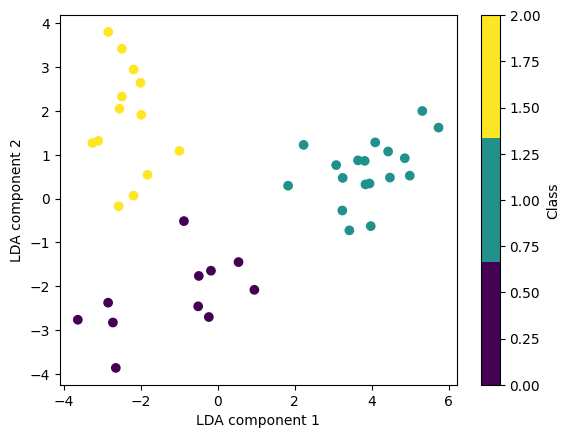

In [ ]:
plt.figure()

cmap = cm.get_cmap("viridis", 3)
plt.scatter(X_tr[:, 0], X_tr[:, 1], c=y_pred, cmap=cmap)
plt.xlabel("LDA component 1")
plt.ylabel("LDA component 2")
plt.colorbar(label="Class")